In [1]:
import pydicom,kornia,skimage
from fastai.vision.all import *
from fastai.medical.imaging import *
from torchvision.utils import save_image
import seaborn as sns

from fmi.pipeline import *
from fmi.explore import *
from fmi.preprocessing import *
from fmi.examine import *
from sklearn.model_selection import train_test_split

import timm
from wwf.vision.timm import *

Introduction.......

Briefy describe fmi process explore.....

link to blog site....

`system_info` conveniently lists the current `fastai`, `fastcore`versions as well as `cuda`, `pydicom` and `kornia` versions

In [2]:
system_info()

fastai Version: 2.2.5
fastcore Version: 1.3.19
python Version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
torchvision: 0.8.1
torch version: 1.7.0

Cuda: True
cuda Version: 11.0
GPU: GeForce GTX 1060

pydicom Version: 2.1.1
kornia Version: 0.2.0


## Explore

### Getting The Data

In [3]:
pneu = untar_data(URLs.SIIM_SMALL)
p_items = get_dicom_files(f'{pneu}/train')
p_items

(#250) [Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000000.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000002.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000005.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000006.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000007.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000008.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000009.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000011.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000012.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000014.dcm')...]

In [4]:
df = pd.read_csv(f'{pneu}/labels.csv')

Dicom metadata contains a wealth of information like the example below.

In [5]:
p_items[0].dcmread()

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

However sometimes it is better to get more targeted information from the metadata.

`get_image_info` provides image specific information such as the Modality, Photometric Interpretation, Pixel Spacing, SliceThickness, Bits Allocated, RescaleIntercept and RescaleSlope.  This information is important when modelling the data.

In [6]:
get_image_info(p_items[0])

(0008, 0060) Modality                            CS: 'CR'
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0030) Pixel Spacing                       DS: [0.168, 0.168]
No SliceThickness
(0028, 0100) Bits Allocated                      US: 8
No Rescale Intercept
No Rescale Slope


When dealing with medical based datasets it is important to know if there are any patient identifiable identifiers within the metadata.  This information if present is important to consider because it may reveal additional information as well as potential bias.  `get_pii` conveniently lists this information as well as looking for the `Image Comments` tag within the metadata that may contain useful information

In [7]:
get_pii(p_items[0])

(0010, 0010) Patient's Name                      PN: '16d7f894-55d7-4d95-8957-d18987f0e981'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '62'
No Image Comments


In [8]:
patient_df = pd.DataFrame.from_dicoms(p_items, window=dicom_windows.lungs)
patient_df[:5]

SpecificCharacterSet                SOPClassUID  \
0           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
1           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
2           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
3           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   
4           ISO_IR 100  1.2.840.10008.5.1.4.1.1.7   

                                            SOPInstanceUID StudyDate  \
0   1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819  19010101   
1  1.2.276.0.7230010.3.1.4.8323329.11028.1517875229.983789  19010101   
2  1.2.276.0.7230010.3.1.4.8323329.11444.1517875232.977506  19010101   
3   1.2.276.0.7230010.3.1.4.8323329.32219.1517875159.70802  19010101   
4  1.2.276.0.7230010.3.1.4.8323329.32395.1517875160.396775  19010101   

   StudyTime AccessionNumber Modality ConversionType ReferringPhysicianName  \
0  000000.00                       CR            WSD                          
1  000000.00                       CR            WSD                          
2  000000.00                       CR            WSD                          
3  000000.00                       CR            WSD                          
4  000000.00                       CR            WSD                          

  SeriesDescription  ... LossyImageCompression LossyImageCompressionMethod  \
0          view: PA  ...                    01                 ISO_10918_1   
1          view: PA  ...                    01                 ISO_10918_1   
2          view: PA  ...                    01                 ISO_10918_1   
3          view: PA  ...                    01                 ISO_10918_1   
4          view: PA  ...                    01                 ISO_10918_1   

                                                                     fname  \
0  C:\Users\avird\.fastai\data\siim_small\train\No Pneumothorax\000000.dcm   
1  C:\Users\avird\.fastai\data\siim_small\train\No Pneumothorax\000002.dcm   
2  C:\Users\avird\.fastai\data\siim_small\train\No Pneumothorax\000005.dcm   
3  C:\Users\avird\.fastai\data\siim_small\train\No Pneumothorax\000006.dcm   
4  C:\Users\avird\.fastai\data\siim_small\train\No Pneumothorax\000007.dcm   

  MultiPixelSpacing PixelSpacing1 img_min img_max    img_mean    img_std  \
0                 1         0.168       0     254  160.398039  53.854885   
1                 1         0.143       0     250  114.524713  70.752315   
2                 1         0.143       0     246  132.218334  73.023531   
3                 1         0.171       0     255  153.405355  59.543063   
4                 1         0.171       0     250  166.198407  50.008985   

  img_pct_window  
0       0.358613  
1       0.620320  
2       0.561823  
3       0.359524  
4       0.345166  

[5 rows x 42 columns]

In [9]:
patient_df['PatientSex'].value_counts()

M    125
F    125
Name: PatientSex, dtype: int64

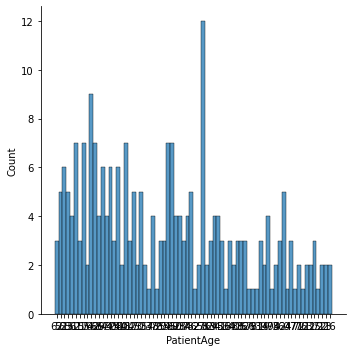

In [10]:
sns.displot(patient_df['PatientAge']);


### Splitting The Data

It is common practice to split the dataset into `train` and `valid`, for example `RandomSplitter` splits the data with a 80:20 split.  However it is also important to ensure that the same patient is not present in both the train and valid splits

In [11]:
trn,val = RandomSplitter(valid_pct=0.2, seed=7)(p_items)

In [12]:
trn, val

((#200) [33,65,231,167,74,127,184,89,122,79...],
 (#50) [115,233,139,163,161,177,57,21,34,99...])

The `SIIM_SMALL` only contains 250 images and you can easily check if duplicates will exist when splitting the data by using `check_duplicates` and specifying a `seed` value.

Train: 200 
 Original Validation: 50 
 Updated Validation: 50


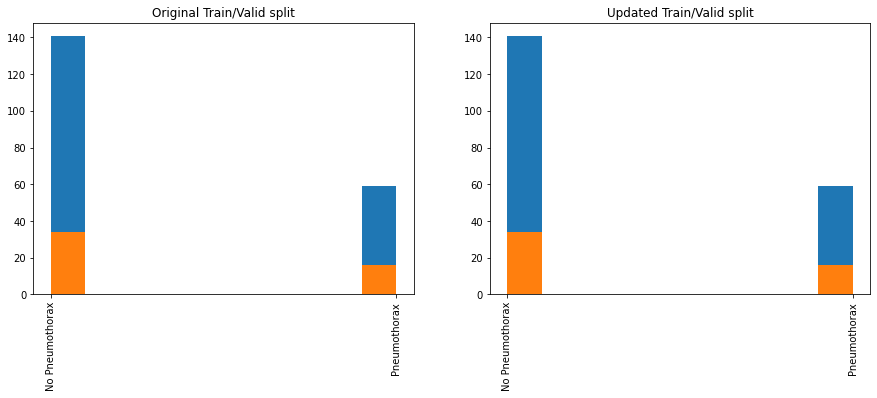

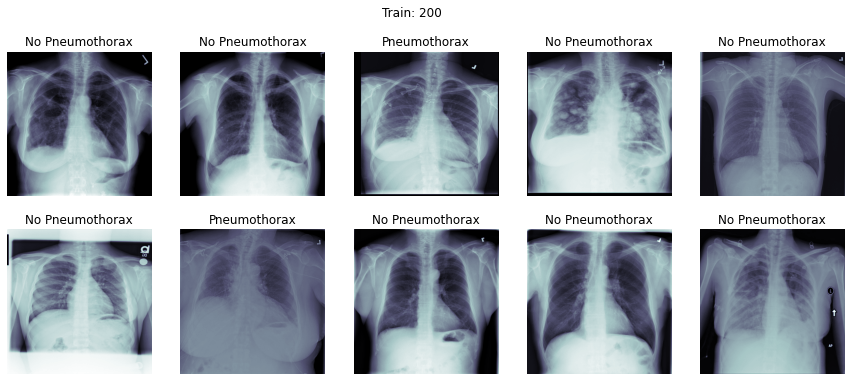

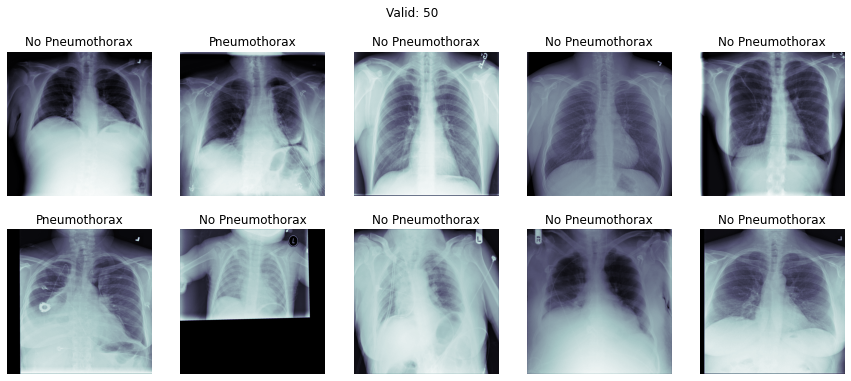

In [13]:
check_duplicate(p_items, valid_pct=0.2, seed=7)

`check_duplicates` displays the number of train and valid images and if there are duplicates it will also display the updated valid count with the duplicates removed from the valid set.  It also displays images from the train and valid sets

The dataset as is does not have any duplicate images and hence the reason why the updated valid count is the same as the original valid count.

**What happens when there is/are duplicates in the train and valid sets?**

To see what happens I have another dataset that contains duplicate images

In [14]:
duplicate_ds = get_dicom_files(f'{pneu}/sm')

Train: 286 
 Original Validation: 71 
 Updated Validation: 30


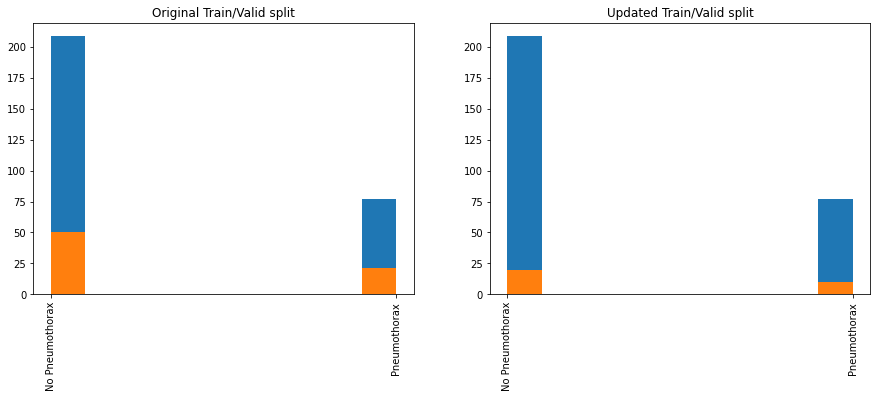

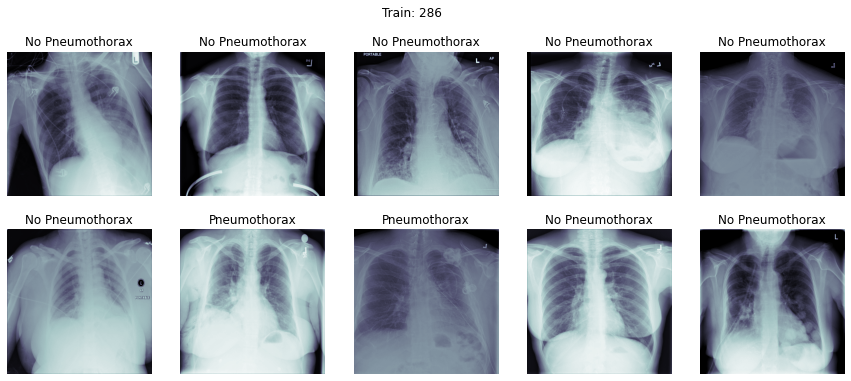

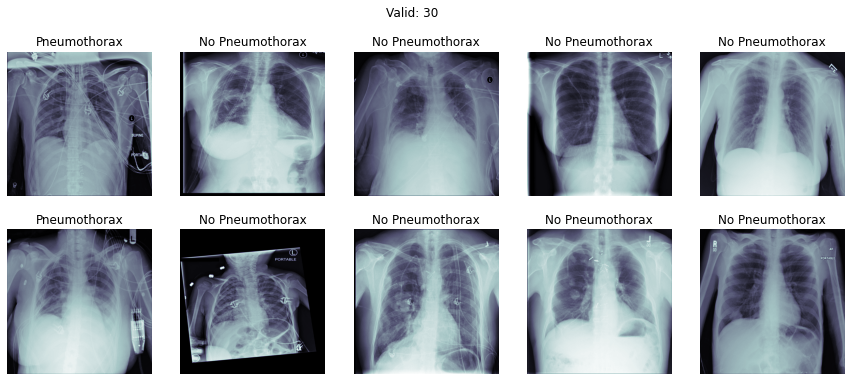

In [15]:
check_duplicate(duplicate_ds, valid_pct=0.2, seed=7)

In this case the original split had 286 images in the train set and 71 images in the validation set.  `check_duplicates` was able to find 41 duplicates in the validation set and removes them from here hence the updated validation count of 30.  However we now know that there are no duplicate patients in the train and validation sets

## PreProcessing

`dicom_splitter` uses the same methodology and this can be passed when creating the `DataBlock`

In [5]:
splitter = dicom_splitter(p_items, valid_pct=0.2, seed=7)

### Create The DataBlock

Specify the `item_tfms` and `batch_tfms` to your specifications

In [167]:
item_tfms = Resize(266)
batch_tfms = [RandomResizedCropGPU(226), *aug_transforms(do_flip=False, flip_vert=False, max_rotate=10.,
                                                         min_zoom=1., max_zoom=1.1, max_lighting=0.2, max_warp=0.1),
                                                         Normalize.from_stats(*imagenet_stats)]

In [168]:
set_seed(7)
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneu/f"{x[0]}",
                   get_y=lambda x:x[1],
                   splitter=splitter,
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)

Note using `num_workers` as 0 because I am using a windows machine

In [8]:
set_seed(7)
dls = pneumothorax.dataloaders(df.values, bs=16, num_workers=0)

200 50


This automatically prints out the number of images in the `train` (200) and `valid` (50) sets because we had earlier used `dicom_splitter`. Note that we are back to using the original `SIIM_SMALL` dataset.

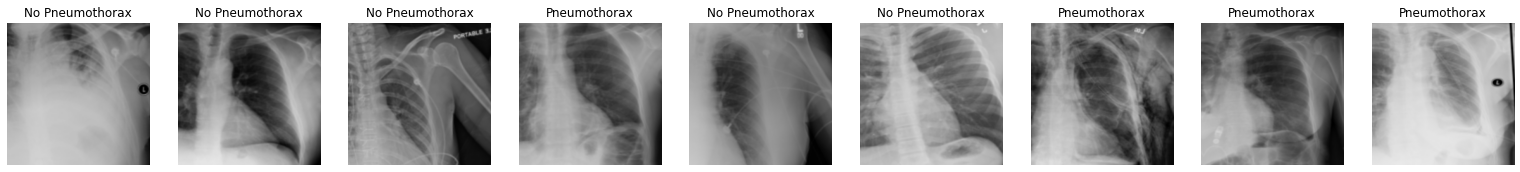

In [9]:
dls.show_batch(nrows=1)

### Simple CNN

Start off with simple neural network

In [10]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def simple_cnn():
    return sequential(
    conv(3 ,4),            #113x113
    conv(4 ,8),            #57x57
    conv(8 ,16),           #28x28
    conv(16,32),           #14x14
    conv(32,64),          #7x7
    conv(64,128),         #4x4
    conv(128,256),        #2x2
    conv(256,2, act=False),#1x1
    Flatten(),
)

Input image will be of size 226 by 226 as specified in `batch_tfms`. The goal is to minimize the number of activation maps from 226 to 2 which is the number of classes we are trying to predict in this case (either the image has pneumothorax or not)

### Callbacks

**Creating your own Callback**

Create a simple callback that prints out the `epoch` and `iteration` number and displayes the images of each batch

In [11]:
class CreateCallback(Callback):
    def after_step(self, **kwargs):
        print(f'EPOCH: {self.epoch} ITER: {self.train_iter}')
        show_images(self.x, suptitle=[self.epoch, self.n_iter])

Other callbacks that are used:

**By Default** (unless you remove them):

**> TrainEvalCallback** - Callback that tracks the number of iterations done and properly sets training/eval mode

**> Recorder** - Callback that registers statistics (lr, loss and metrics) during training

**> ProgressCallback** - Callback to handle the display of progress bars

The other Callbacks used in this tutorial:

**> ShowGraphCallback** - Callback that updates a graph of training and validation loss

**> ActivationStats** - Callback that record the mean and std of activations (note: if you want to view the activations change `with_hist` to `True`, by default it is `False`

### Class Imbalance

It is important to consider the distribution of classes in this dataset both in the train and valid sets. Using `dicomsplit` we can access the file paths of the train set

In [142]:
trn, new_val, val, train_L, val_L, new_val_o = dicomsplit(valid_pct=0.2, seed=7)(p_items)
train_L[-1]

(#200) [Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000044.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000093.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/Pneumothorax/000187.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000241.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000103.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000182.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/Pneumothorax/000042.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000123.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000176.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000110.dcm')...]

Now you can view the distribution of classes in the train dataset.  We would first have to create a function that can read the class of the images.

In [144]:
def get_lb(fn):
    fn = str(fn)
    lb = fn.split('\\')[-2]
    return lb

In [145]:
labels = [get_lb(item) for item in train_L[-1]]
Counter(labels)

Counter({'No Pneumothorax': 141, 'Pneumothorax': 59})

There are more `No Pneumothorax` images than `Pneumothorax` images.  We now see what the distribution of the classes would be with the current dataloader.  This was inspired by this [thread](https://forums.fast.ai/t/issue-with-weighteddl/88125/2). Fastai has a handy function `datasets` that makes it pretty easy to view the train and valid sets.

In [148]:
dset = pneumothorax.datasets(df.values)
dset

200 50


(#250) [(PILDicom mode=L size=1024x1024, TensorCategory(0, dtype=torch.int32)),(PILDicom mode=L size=1024x1024, TensorCategory(1, dtype=torch.int32)),(PILDicom mode=L size=1024x1024, TensorCategory(0, dtype=torch.int32)),(PILDicom mode=L size=1024x1024, TensorCategory(1, dtype=torch.int32)),(PILDicom mode=L size=1024x1024, TensorCategory(1, dtype=torch.int32)),(PILDicom mode=L size=1024x1024, TensorCategory(0, dtype=torch.int32)),(PILDicom mode=L size=1024x1024, TensorCategory(0, dtype=torch.int32)),(PILDicom mode=L size=1024x1024, TensorCategory(0, dtype=torch.int32)),(PILDicom mode=L size=1024x1024, TensorCategory(0, dtype=torch.int32)),(PILDicom mode=L size=1024x1024, TensorCategory(0, dtype=torch.int32))...]

This is the dataloader we used above

In [184]:
set_seed(7)
dls = pneumothorax.dataloaders(df.values, bs=32, num_workers=0)

200 50


In [185]:
for i in range(10):
    x,y = dls.one_batch()
    print(sum(y)/len(y))

tensor(0.3750, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.2812, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(0.4062, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(0.2188, device='cuda:0')


By calling the dataloader 10 times we can see that the distribution of labels vary between 0.0625 and 0.4375 so not 50:50.

Now lets see what the distribution is using `WeightedDL`

In [190]:
del dls

In [191]:
count = Counter(labels)
wgts = [1/count[dset.vocab[label]] for img, label in dset.train]
len(wgts)

200

In [192]:
set_seed(7)
dls = pneumothorax.dataloaders(df.values, bs=32, num_workers=0, dl_type=WeightedDL, wgts=wgts)

200 50


In [193]:
for i in range(10):
    x,y = dls.one_batch()
    print(sum(y)/len(y))

tensor(0.5000, device='cuda:0')
tensor(0.5312, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.4688, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.4375, device='cuda:0')
tensor(0.4688, device='cuda:0')
tensor(0.4375, device='cuda:0')
tensor(0.3438, device='cuda:0')


Using `WeightedDL` we can now see that the distribution of the labels is rougly 50%

In [131]:
dls = pneumothorax.dataloaders(df.values, num_workers=0, dl_type=WeightedDL, wgts=wgts)

200 50


In [134]:
for i in range(10):
    x, y = dls.one_batch()
    print(sum(y)/len(y))

tensor(0.3906, device='cuda:0')
tensor(0.4531, device='cuda:0')
tensor(0.4844, device='cuda:0')
tensor(0.5156, device='cuda:0')
tensor(0.4375, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.4844, device='cuda:0')
tensor(0.6562, device='cuda:0')
tensor(0.5781, device='cuda:0')
tensor(0.5312, device='cuda:0')


We now use the `WeightedDL` to create the `Learner`.  We also use the callback `CreateCallback` we created earlier.

In [194]:
learn = Learner(dls, 
                simple_cnn(), 
                loss_func=LabelSmoothingCrossEntropyFlat(), 
                metrics=accuracy, 
                cbs=[ShowGraphCallback(), ActivationStats(with_hist=True), CreateCallback()])

`fastai` has a handy feature that will display the whole training loop and show where each callback is called within the loop

In [195]:
learn.show_training_loop()

Start Fit
   - before_fit     : [ActivationStats, TrainEvalCallback, Recorder, ProgressCallback, ShowGraphCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ActivationStats]
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : [CreateCallback]
         - after_cancel_batch: []
         - after_batch    : [ActivationStats, TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback, ShowGraphCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_v

Looking at the training loop you can see that `CreateCallback` will be called during the `after_step` step because that is what was specified in the callback.

c:\users\avird\anaconda3\envs\fastainew\lib\site-packages\fastai\callback\core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


EPOCH: 0 ITER: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

EPOCH: 0 ITER: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

EPOCH: 0 ITER: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

EPOCH: 0 ITER: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

EPOCH: 0 ITER: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

EPOCH: 0 ITER: 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

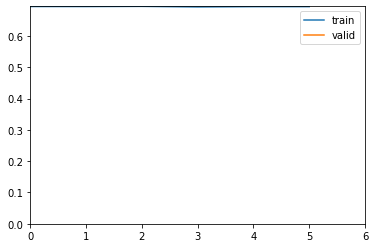

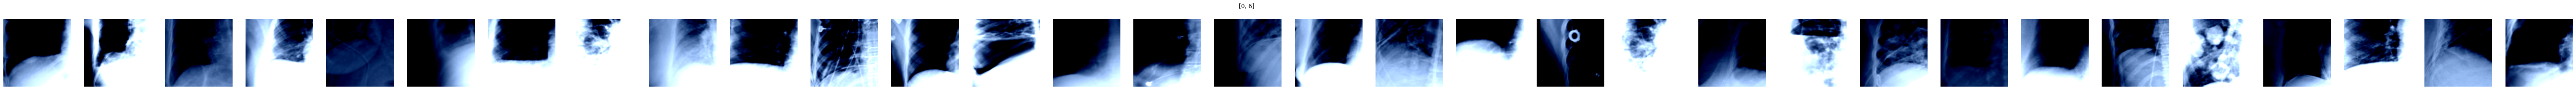

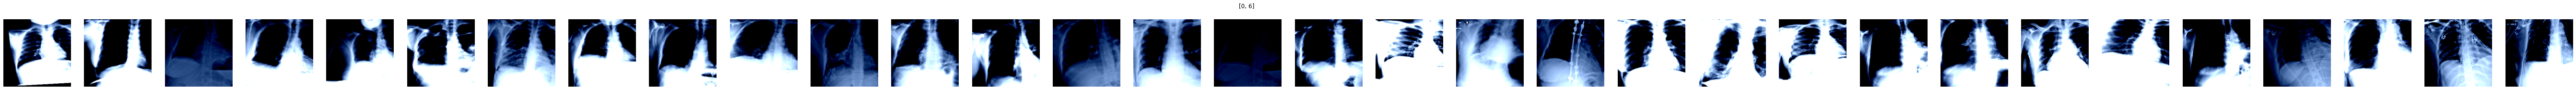

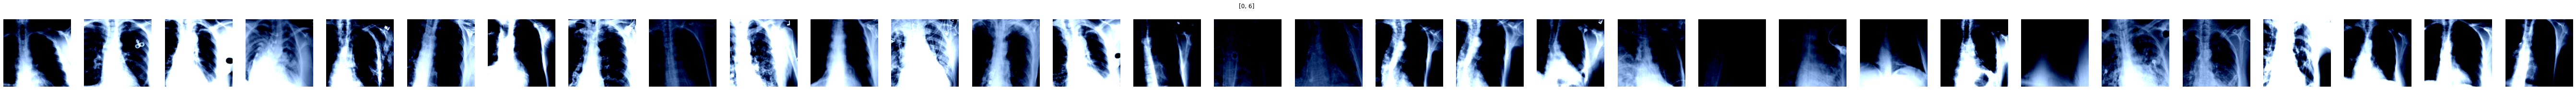

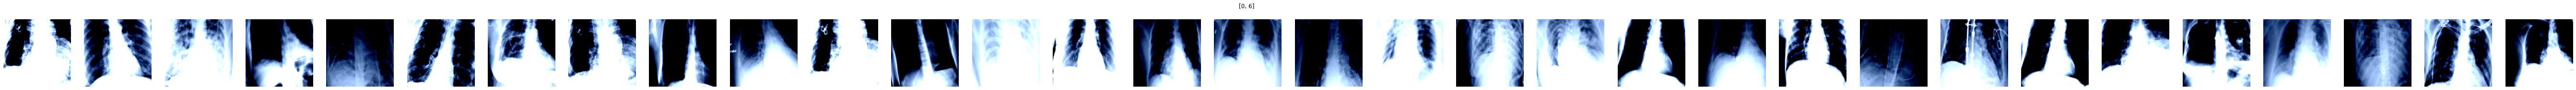

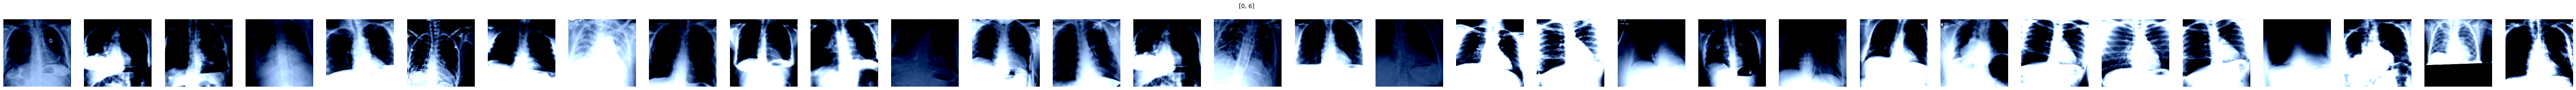

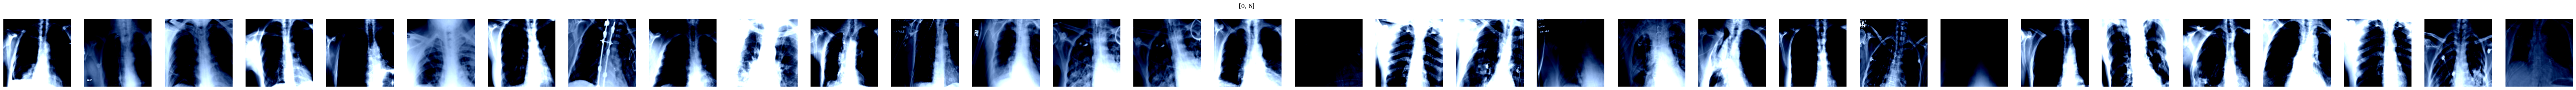

In [196]:
learn.fit_one_cycle(1, 1e-3)

We trained for 1 epoch using a batch size of 32.  There will be 5 iterations in each epoch.  An epoch can be described as the number of times the model sees the entire data set whilst an iteration is the number of times a batch of data passes through the model.

The images at the end represent the 5 iterations (each of batch size 32) hence the 5 rows of images each containing the 32 images.

The 6th row shows you the images that are present in the validation set.

In [197]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (6): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (7): Conv2d(256, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): Flatten(full=False)
)

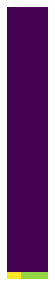

In [198]:
matplotlib.rcParams['image.cmap'] = 'viridis'
learn.activation_stats.color_dim(-1)

The `color_dim` displays the activations during the learning phase.  In this case the graph is narrow because we only trained the model with 1 epoch.  As we train with more epochs the graph grows horizontally.

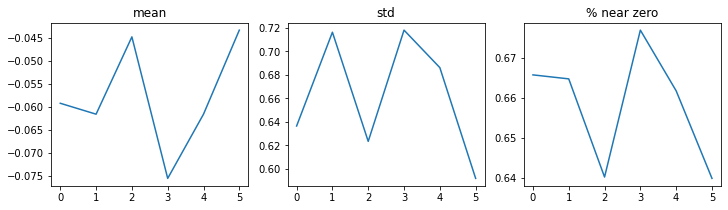

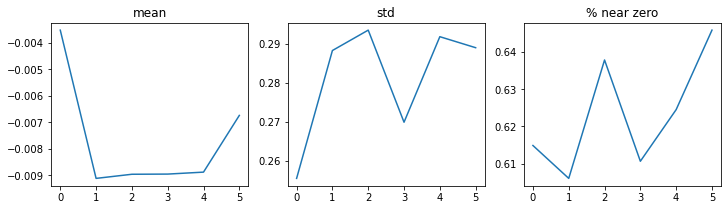

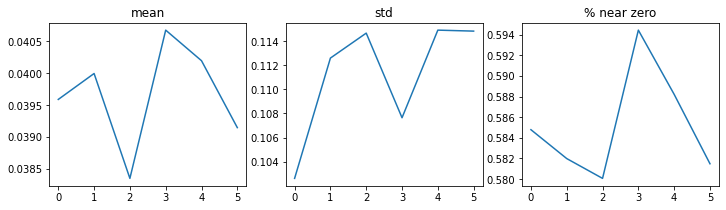

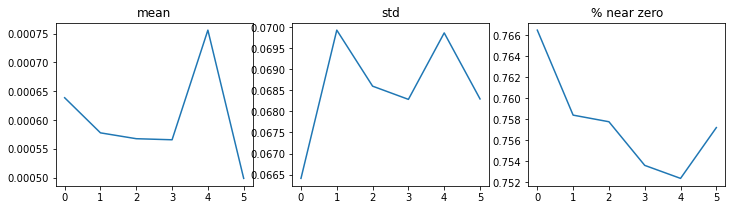

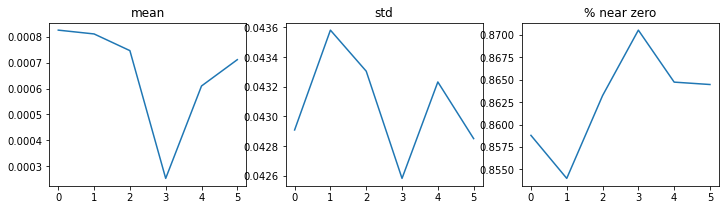

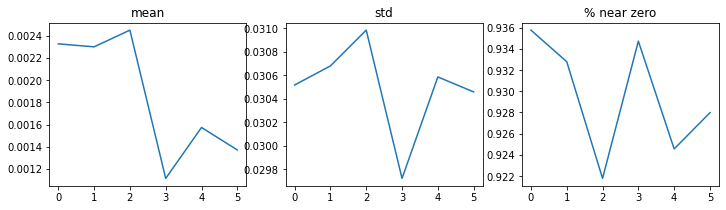

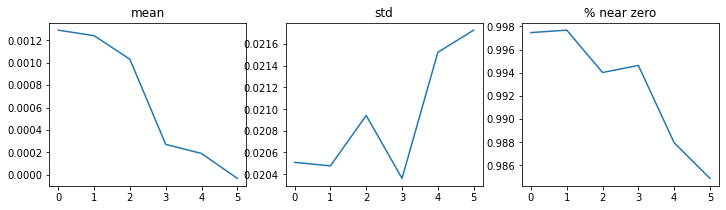

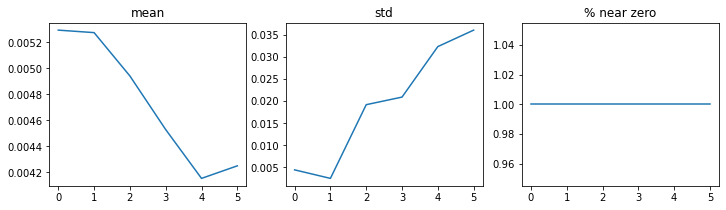

In [199]:
for i in range(0,8):
    learn.activation_stats.plot_layer_stats(i)

In [200]:
learn.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 4 x 113 x 113  
Conv2d                                    112        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 8 x 57 x 57    
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 16 x 29 x 29   
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 32 x 15 x 15   
Conv2d                                    4640       True      
ReLU                                                        

## Test Files

In [201]:
test_path = 'C:/Users/avird/.fastai/data/siim_small/Test/No_Pnuemo'
test_files = get_dicom_files(test_path)
test_files

(#24) [Path('C:/Users/avird/.fastai/data/siim_small/Test/No_Pnuemo/000032.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/Test/No_Pnuemo/000033.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/Test/No_Pnuemo/000034.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/Test/No_Pnuemo/000035.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/Test/No_Pnuemo/000036.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/Test/No_Pnuemo/000037.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/Test/No_Pnuemo/000039.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/Test/No_Pnuemo/000040.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/Test/No_Pnuemo/000041.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/Test/No_Pnuemo/000044.dcm')...]

In [202]:
test_i = test_files[7]
test_im = PILDicom.create(test_i)

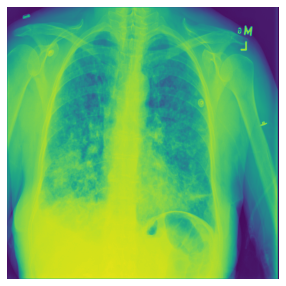

In [203]:
show_image(PILDicom.create(test_files[0]));

### View Layers

In [204]:
layers = flatten_model(learn.model)
layers

[Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(256, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Flatten(full=False)]

### Layer 1

`view_layers` is a handy `fmi` function that prints out the layer, number of activations, image shape and images of that layer.

Layer: Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Number of activations: 4
Image shape: (113, 113)


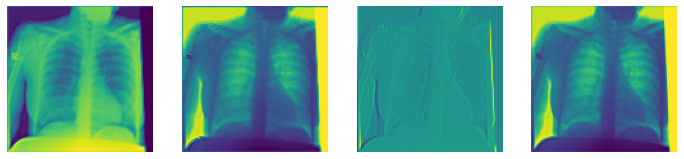

In [205]:
view_layers(test_im,0, layers, learn)

### Layer 1 ReLU

Layer: ReLU()
Number of activations: 4
Image shape: (113, 113)


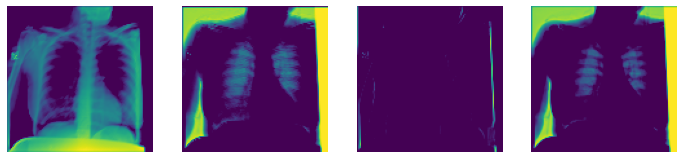

In [206]:
view_layers(test_im,1, layers, learn)

### Layer 2

Layer: Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Number of activations: 8
Image shape: (57, 57)


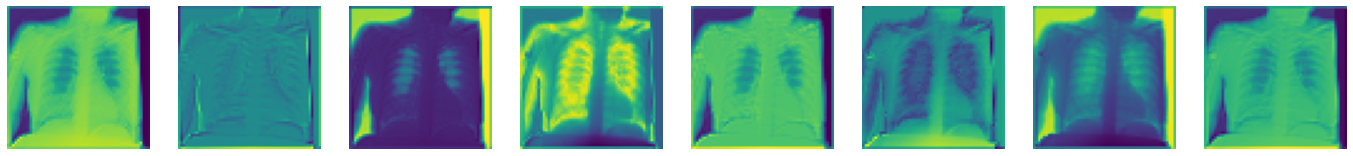

In [207]:
view_layers(test_im,2, layers, learn)

### Layer 2 ReLU

Layer: ReLU()
Number of activations: 8
Image shape: (57, 57)


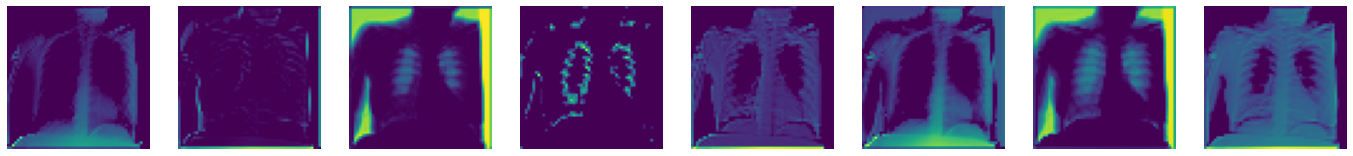

In [208]:
view_layers(test_im,3, layers, learn)

### Layer 3

Layer: Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Number of activations: 16
Image shape: (29, 29)


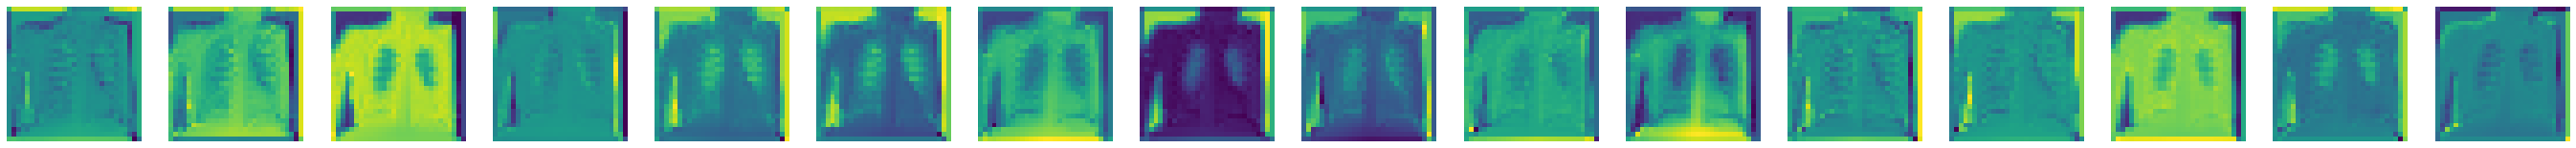

In [209]:
view_layers(test_im,4, layers, learn)

### Layer 3 ReLU

Layer: ReLU()
Number of activations: 16
Image shape: (29, 29)


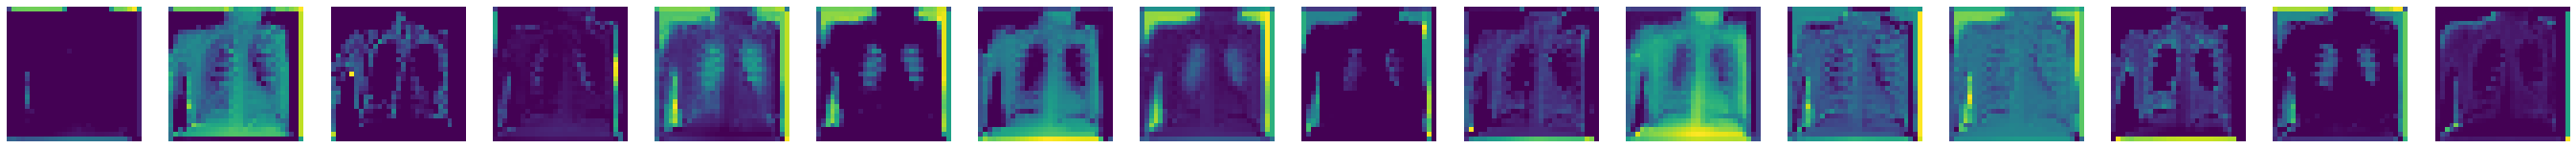

In [210]:
view_layers(test_im,5, layers, learn)

### Layer 4

Layer: Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Number of activations: 32
Image shape: (15, 15)


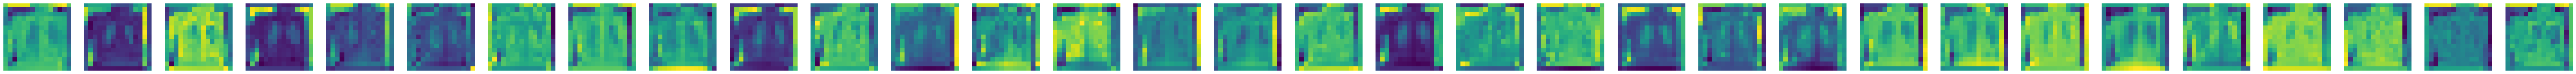

In [211]:
view_layers(test_im,6, layers, learn)

### Layer 4 ReLU

Layer: ReLU()
Number of activations: 32
Image shape: (15, 15)


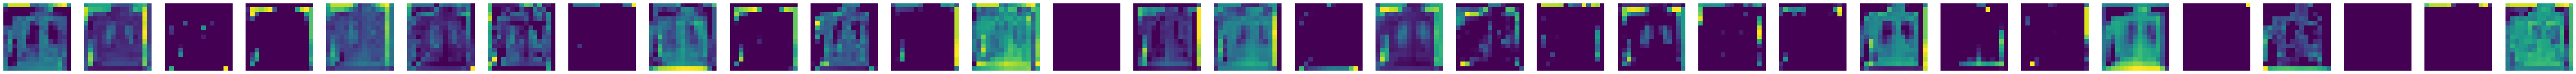

In [212]:
view_layers(test_im,7, layers, learn)

### Layer 5

Layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Number of activations: 64
Image shape: (8, 8)


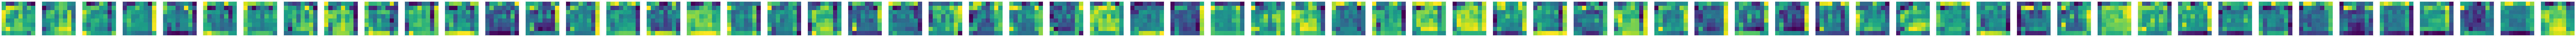

In [213]:
view_layers(test_im,8, layers, learn)

### Layer 5 ReLU

Layer: ReLU()
Number of activations: 64
Image shape: (8, 8)


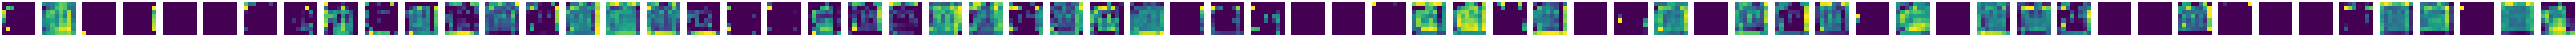

In [214]:
view_layers(test_im,9, layers, learn)

In [215]:
x, = first(dls.test_dl([test_im]))

In [216]:
cls = 1

Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


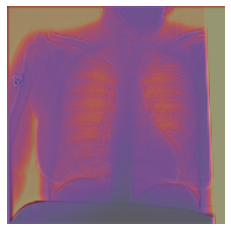

In [217]:
view_activations(x, cls, dls, learn, learn.model[0][0])

Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


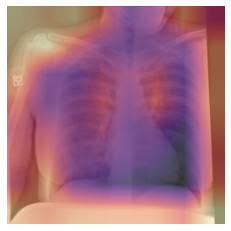

In [218]:
view_activations(x, cls, dls, learn, learn.model[4][0])

Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


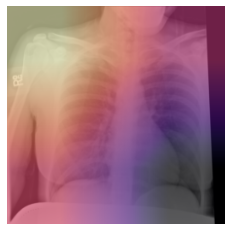

In [219]:
view_activations(x, cls, dls, learn, learn.model[6][0])

Conv2d(256, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


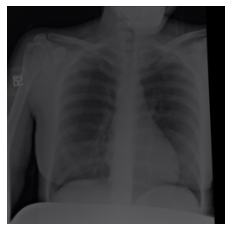

In [220]:
view_activations(x, cls, dls, learn, learn.model[7])

## Interpretation

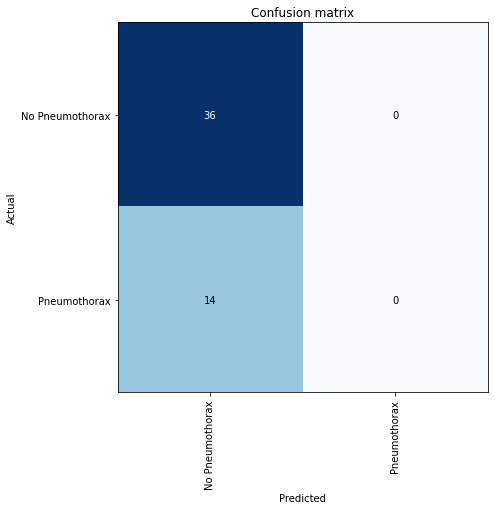

In [221]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [222]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

36 0 14 0


In [223]:
specificity = tn/(fp + tn)
specificity

1.0

In [224]:
sensitivity = tp/(tp + fn)
sensitivity

0.0

In [225]:
ppv = tp/(tp+fp)
ppv

c:\users\avird\anaconda3\envs\fastainew\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in longlong_scalars
  """Entry point for launching an IPython kernel.


nan

In [226]:
npv = tn/(tn+fn)
npv

0.72